In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

from icecream import ic
from cop_diffusion.utils import save_model, load_model


device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

In [2]:
def load_cifar():
    train = datasets.CIFAR10(root="data", train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                     (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                             ]))

    val = datasets.CIFAR10(root="data", train=False, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))
    return train, val

def data_loaders(train_data, val_data, batch_size):

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)
    val_loader = DataLoader(val_data,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True)
    return train_loader, val_loader

training_data, validation_data = load_cifar()
training_loader, validation_loader = data_loaders(
training_data, validation_data, batch_size=10)
x_train_var = np.var(training_data.data / 255.0)

Files already downloaded and verified
Files already downloaded and verified


https://github.com/MishaLaskin/vqvae/tree/master

In [3]:
class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x




In [4]:
# random data
x = np.random.random_sample((3, 40, 40, 200))
x = torch.tensor(x).float()
# test Residual Layer
res = ResidualLayer(40, 40, 20)
res_out = res(x)
print('Res Layer out shape:', res_out.shape)
# test res stack
res_stack = ResidualStack(40, 40, 20, 3)
res_stack_out = res_stack(x)
print('Res Stack out shape:', res_stack_out.shape)

Res Layer out shape: torch.Size([3, 40, 40, 200])
Res Stack out shape: torch.Size([3, 40, 40, 200])


In [5]:

class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta 
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)

        )

    def forward(self, x):
        return self.conv_stack(x)



In [6]:
# random data
x = np.random.random_sample((3, 40, 40, 200))
x = torch.tensor(x).float()

# test encoder
encoder = Encoder(40, 128, 3, 64)
encoder_out = encoder(x)
print('Encoder out shape:', encoder_out.shape)

Encoder out shape: torch.Size([3, 128, 10, 50])


In [7]:
class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi 
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)



In [8]:
# random data
x = np.random.random_sample((3, 40, 40, 200))
x = torch.tensor(x).float()

# test decoder
decoder = Decoder(40, 128, 3, 64)
decoder_out = decoder(x)
print('Dncoder out shape:', decoder_out.shape)

Dncoder out shape: torch.Size([3, 3, 160, 800])


In [9]:
class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, channel, height, width)

        quantization pipeline:

            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)

        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices

In [10]:
class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(
            z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity

In [11]:

batch_size = 32
n_updates = 5000
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim=64
n_embeddings=512
beta=.25
learning_rate=3e-4
log_interval=100
dataset='CIFAR10'

model_version = "0.1"
model_name="vqvae"

model = VQVAE(n_hiddens, n_residual_hiddens,
              n_residual_layers, n_embeddings, embedding_dim, beta).to(device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
model.train();

training_loader, validation_loader = data_loaders(
    training_data, validation_data, batch_size=batch_size)
x_train_var = np.var(training_data.data / 255.0)


In [14]:
from datetime import datetime


results = {
    'n_updates': 0,
    'recon_errors': [],
    'loss_vals': [],
    'perplexities': [],
}
save:bool = True
n_updates=2001
last_update = 0
if last_update > 0:
    model = load_model(model_name=model_name, model_version=model_version, iter=last_update)
    from_update_nb = last_update + 1
else:
    from_update_nb = 0
writer = SummaryWriter(
            f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )    
split = 'train'
for i in range(from_update_nb, n_updates):
    (x, _) = next(iter(training_loader))
    
    x = x.to(device)
    optimizer.zero_grad()

    embedding_loss, x_hat, perplexity = model(x)
    recon_loss = torch.mean((x_hat - x)**2) / x_train_var
    loss = recon_loss + embedding_loss

    loss.backward()
    optimizer.step()

    results["recon_errors"].append(recon_loss.cpu().detach().numpy())
    results["perplexities"].append(perplexity.cpu().detach().numpy())
    results["loss_vals"].append(loss.cpu().detach().numpy())
    results["n_updates"] = i

    if i % log_interval == 0:
        inter_recon_errors = np.mean(results["recon_errors"][-log_interval:])
        inter_loss = np.mean(results["loss_vals"][-log_interval:])
        inter_perplexity = np.mean(results["perplexities"][-log_interval:])
       
        writer.add_scalar(f"{split} loss", inter_loss, i)
        writer.add_scalar(f"{split} recon_errors", inter_recon_errors, i)
        writer.add_scalar(f"{split} perplexity", inter_perplexity, i)
if save:
    save_model(model=model,model_name=model_name, model_version=model_version,iter=i)


In [33]:
def display_image_grid(x):
    x = make_grid(x.cpu().detach()+0.5)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].


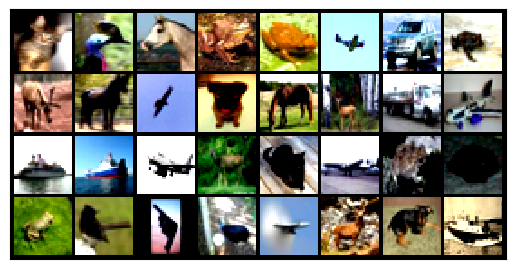

In [34]:
x, _ = next(iter(training_loader))
display_image_grid(x)

In [35]:
def reconstruct(data_loader,model):
    (x, _) = next(iter(data_loader))
    x = x.to(device)
    vq_encoder_output = model.pre_quantization_conv(model.encoder(x))
    _, z_q, _, _,e_indices = model.vector_quantization(vq_encoder_output)
    
    x_recon = model.decoder(z_q)
    return x,x_recon, z_q,e_indices

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].


torch.Size([32, 3, 32, 32])


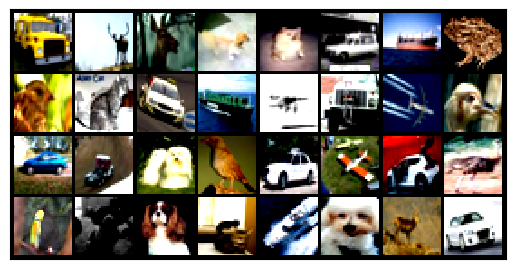

In [36]:
x_val,x_val_recon,z_q,e_indices = reconstruct(validation_loader,model)
print(x_val.shape)
display_image_grid(x_val)

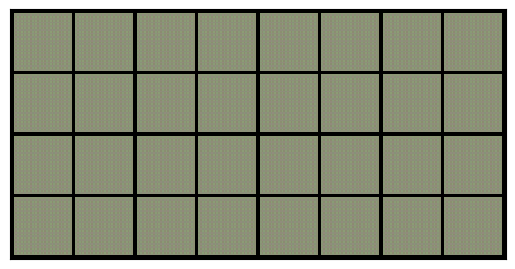

In [37]:
display_image_grid(x_val_recon)